In [1]:
import numpy as np 
import re 
import requests as req 
import itertools as it
import matplotlib.pyplot as plt 
import pandas as pd 
from sodapy import Socrata
import geopy as gp
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import collections as col
from imblearn.over_sampling import SMOTENC, SMOTEN, SMOTE
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

In [2]:
#FOUND API. no need for requests
# requ_url = 'https://www.dot.ny.gov/portal/pls/portal/MEXIS_APP.DYN_PROJECT_DETAILS.show'
# req_post = {'p_arg_names': 'p_pin', 'p_arg_values':801079}
# # resp = req.get(requ_url)
# def data_retrieval(url: str, key: list[str]) -> pd.DataFrame:
#     response = req.get(url)
#     if response.ok == True and response.status_code == 200:
#         print('Success')
#     else:
#         print('Failed')
#     data = response.json()
#     return data
# response = req.get(requ_url, params=req_post)
# print(response.text)

In [2]:
client = Socrata("data.ny.gov",app_token='SUV6CnpKWErb1fdYcxWDEXpHl', username='dwightdinkins@gmail.com',password='AVelaryon@2134')
results = client.get("rz8t-4kmq", limit=5000)
results_df = pd.DataFrame.from_records(results)
results_df.shape

(1937, 23)

In [6]:
results_df

,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,...,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date,construction_start_date,construction_end_date,construction_amount
0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,No,...,16193713,1387827.44,17581540.44,2020-11-25T00:00:00.000,GREEN,YELLOW,NaN,NaN,NaN,NaN
1,000822,NaN,10 LONG ISLAND,South Ferry Dock at NY114 Improvements,Improve South Ferry Dock at NY114 including re...,In Development,Summer 2022,Yes,Yes,No,...,NaN,NaN,NaN,NaN,NaN,NaN,Spring 2020,Summer 2022,Summer 2023,3100000
2,000823,NaN,10 LONG ISLAND,NY114 Pavement Resurfacing Stephen Hands Path ...,NY114 Pavement Resurfacing from Stephen Hands ...,In Development,Summer 2021,Yes,Yes,No,...,NaN,NaN,NaN,NaN,NaN,NaN,Spring 2020,Fall 2021,Winter 2022/2023,9600000
3,001145,D264139,10 LONG ISLAND,NY231 LAKE TO I495 CONCRETE PAVEMENT REPAIR,Concrete Pavement repair including joint seali...,Under Construction,01/09/2020,Yes,Yes,No,...,4560000,283654.94,4843654.94,2021-07-06T00:00:00.000,GREEN,YELLOW,Fall 2018,NaN,NaN,NaN
4,001627,D263744,10 LONG ISLAND,NY112 RECONS I495 TO GRANNY RD,Reconstruction of NY112 between I495 and Grann...,Under Construction,06/21/2018,Yes,Yes,No,...,32687178,-1029161.6,31658016.4,2021-09-30T00:00:00.000,YELLOW,GREEN,Fall 2014,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1932,XM2402,NaN,11 NEW YORK CITY,"REGIONAL BRIDGE WASHING, ALL COUNTIES IN NYC","Regional bridge washing, all counties in New Y...",Future Development,Fall 2024,Yes,Yes,No,...,NaN,NaN,NaN,NaN,NaN,NaN,Summer 2023,Winter 2024/2025,Spring 2025,4200000
1933,XM2460,NaN,11 NEW YORK CITY,RETAINING WALLS INSPECTION AND CORRECTIVE MAIN...,The objectives of this project are to ensure p...,Future Development,Fall 2024,Yes,Yes,No,...,NaN,NaN,NaN,NaN,NaN,NaN,Spring 2021,Fall 2024,Winter 2026/2027,5000000
1934,XM2521,NaN,11 NEW YORK CITY,"WHERE AND WHEN BRIDGE STEEL REPAIRS, ALL COUNT...",Perform emergency steel repairs to maintain st...,Future Development,Fall 2024,No,Yes,No,...,NaN,NaN,NaN,NaN,NaN,NaN,Winter 2022/2023,Winter 2024/2025,Summer 2027,10000000
1935,XM2730,NaN,11 NEW YORK CITY,PAVEMENT PRESERVATION - CRACKS AND JOINTS SEAL...,PREVENTIVE MAINTENANCE OF PAVMENT BY FILLING &...,Future Development,Winter 2026/2027,No,Yes,No,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter 2026/2027,NaN,2200000


In [7]:
results_df[results_df.contract_award_amount.notnull()]

,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,...,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date,construction_start_date,construction_end_date,construction_amount
0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,No,...,16193713,1387827.44,17581540.44,2020-11-25T00:00:00.000,GREEN,YELLOW,NaN,NaN,NaN,NaN
3,001145,D264139,10 LONG ISLAND,NY231 LAKE TO I495 CONCRETE PAVEMENT REPAIR,Concrete Pavement repair including joint seali...,Under Construction,01/09/2020,Yes,Yes,No,...,4560000,283654.94,4843654.94,2021-07-06T00:00:00.000,GREEN,YELLOW,Fall 2018,NaN,NaN,NaN
4,001627,D263744,10 LONG ISLAND,NY112 RECONS I495 TO GRANNY RD,Reconstruction of NY112 between I495 and Grann...,Under Construction,06/21/2018,Yes,Yes,No,...,32687178,-1029161.6,31658016.4,2021-09-30T00:00:00.000,YELLOW,GREEN,Fall 2014,NaN,NaN,NaN
5,001767,D264097,10 LONG ISLAND,RMC/FIRE ISLAND INLET BRIDGE REHAB,Rehabilitate the Robert Moses Causeway bridge ...,Under Construction,01/09/2020,Yes,Yes,No,...,17900000,0,17900000,2021-12-01T00:00:00.000,GREEN,GREEN,Summer 2018,NaN,NaN,NaN
7,003014,D264134,10 LONG ISLAND,NY454 DRAINAGE FEUEREISEN TO JOHNSON,DRAINAGE RECONSTRUCTION ON NY454 BETWEEN FEUER...,Under Construction,02/06/2020,Yes,Yes,No,...,10849000,5090.93,10854090.93,2021-10-31T00:00:00.000,GREEN,GREEN,Fall 2005,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,XM2055,D264367,11 NEW YORK CITY,RESEALING AND REPLACEMENT OF BRIDGE DECK JOINT...,This project involves deck joint resealing/rep...,Under Construction,01/07/2021,Yes,Yes,No,...,10745454.6,-1,10745453.6,2023-09-19T00:00:00.000,GREEN,GREEN,Winter 2018/2019,NaN,NaN,NaN
1913,XM2101,D264351,11 NEW YORK CITY,REGIONAL DRAINAGE CLEANING ON BRIDGES AND HIGH...,Regional Drainage Cleaning on Highways and Bri...,Under Construction,03/11/2021,No,Yes,No,...,4743800,0,4743800,2023-04-12T00:00:00.000,GREEN,GREEN,Fall 2019,NaN,NaN,NaN
1914,XM2121,D264312,11 NEW YORK CITY,"WHERE AND WHEN BRIDGE STEEL REPAIRS, ALL COUNT...",Perform emergency steel repairs to maintain st...,Under Construction,09/24/2020,No,Yes,No,...,8677925,1,8677926,2022-12-12T00:00:00.000,GREEN,GREEN,Fall 2018,NaN,NaN,NaN
1918,XM2145,D264326,11 NEW YORK CITY,WHERE AND WHEN NON-STRUCTURAL CORRECTIVE MAINT...,This project will perform non-structural repai...,Under Construction,10/22/2020,No,Yes,No,...,11276800,0,11276800,2022-03-01T00:00:00.000,GREEN,GREEN,Fall 2019,NaN,NaN,NaN


# Data Pre-processing

In [3]:
group_status = results_df.groupby(by='status', as_index=False)
indx = (results_df.status.str.contains('Completed Project', regex=False).to_numpy() == 1).nonzero()

In [4]:
pd.set_option('display.max_columns', 23)
completed = results_df.iloc[indx[0],:].copy()
# Converted COntract Award Date & Estimated Completion Date to Datetime Objects
completed.contract_award_date = pd.to_datetime(completed.contract_award_date)
completed.estimated_or_actual_completed_date = pd.to_datetime(completed.estimated_or_actual_completed_date)

In [6]:
completed_dropped_contruct = completed.drop(columns=['construction_start_date', 'construction_end_date', 'construction_amount']).copy()

In [6]:
completed_dropped_contruct

,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,type_of_work,public_friendly_description,contract_award_date,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date
0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,No,Bicycle Facility (Highway): New,Project proposes to construct the 3rd phase of...,2019-07-12,16193713,1387827.44,17581540.44,2020-11-25,GREEN,YELLOW,NaN
17,005927,D263713,10 LONG ISLAND,NY27 OAKDALE MERGE INTERCHANGE IMPVTS,NY27 Oakdale Merge Interchange Impvts - resurf...,Completed Project,06/07/2018,No,Yes,Yes,Pavement: Mill and Fill,"This project is located at the Oakdale Merge, ...",2018-08-16,7281160.4,357766.98,7638927.38,2020-09-14,RED,GREEN,Spring 2017
20,011260,D263735,10 LONG ISLAND,NY110 PEDESTRIAN SAFETY IMPROVEMENTS,Pedestrian safety improvements along NY110 be...,Completed Project,06/07/2018,Yes,Yes,No,Pedestrian Facility (Highway): Improve/Rehab,This project proposes to provide upgraded pede...,2018-07-23,3980019.75,459342.64,4439362.39,2020-09-18,RED,RED,Summer 2016
21,012112,D263907,10 LONG ISLAND,NY106 CONC PAVMT REPAIR NY24 TO OLD COUNTRY RD,CONCRETE PAVEMENT REPAIRS ON NY106 FROM NY24 T...,Completed Project,03/14/2019,Yes,Yes,No,"Pavement: Concrete Pavement Repair, Heavy",This project proposes to provide concrete pave...,2019-04-25,6820426.55,161953.24,6982379.79,2020-12-10,RED,GREEN,Winter 2016/2017
29,033915,D264032,10 LONG ISLAND,SMSP GUIDERAIL REHAB I495 TO END,REPAIR AND REPLACE GUIDERAIL SECTIONS SUNKEN M...,Completed Project,09/12/2019,Yes,Yes,No,Guiderail/Median Barrier: Rehab/Improve,This project proposes to replace existing the ...,2019-11-06,4464797.2,218.09,4465015.29,2021-06-18,GREEN,GREEN,Summer 2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,XM1850,D264063,11 NEW YORK CITY,"ADA REQUIREMENTS IN BRONX CO., NYC","Build curb ramps, crosswalks and sidewalks at ...",Completed Project,11/21/2019,Yes,Yes,No,Pedestrian Facility (Highway): Improve/Rehab,This project will build (either throught repla...,2020-01-08,874049.9,-282679.6,591370.3,2020-10-08,GREEN,GREEN,Fall 2018
1903,XM1860,D263918,11 NEW YORK CITY,CORRECTIVE & PREVENTIVE MAINTENANCE OF RETAINI...,CORRECTIVE AND REVENTIVE MAINTENANCE OF MASON...,Completed Project,03/28/2019,Yes,Yes,No,Retaining Wall: New/Improve/Rehab,"This project will repair and restore brick, st...",2019-06-25,14199865.45,-575172.71,13624692.74,2020-11-17,GREEN,GREEN,Summer 2015
1904,XM1921,D263839,11 NEW YORK CITY,"WHERE AND WHEN BRIDGE STEEL REPAIRS, ALL COUNT...",Perform emergency steel repairs to maintain st...,Completed Project,11/29/2018,No,Yes,No,Emergency Response Bridge Repair,This project will perform emergency steel repa...,2019-01-17,10555555,-690065.36,9865489.64,2021-01-19,GREEN,GREEN,Spring 2018
1905,XM1922,D263809,11 NEW YORK CITY,"CORRECTIVE MAINTENANCE REPAIR CONTRACT (NSCO),...","Address NSCO, flags & other conditions on brid...",Completed Project,12/13/2018,No,Yes,No,Emergency Response Bridge Repair,This project will perform maintenance repairs ...,2019-04-16,26680095,1113136.22,27793231.22,2020-10-19,RED,GREEN,Spring 2018


In [5]:

def modify_addy(regex: list[str], data: pd.DataFrame, dat_col: pd.Series):
    geolocator = Nominatim(user_agent='myGeocoder', timeout=10)
    geolocator = RateLimiter(geolocator.geocode, min_delay_seconds=1)
    hwy_data = dat_col.str.replace(regex[0],r'\1-\2', regex=True).str.extract(regex[1]).dropna()
    loc_data = col.defaultdict(dict)
    for indx, hwy in hwy_data.to_dict()[0].items():
        try:
            location = geolocator(hwy + ', NY', geometry='geojson')
            if location != None:
                loc_data['latitude'][indx] = location.latitude
                loc_data['longitude'][indx] = location.longitude
                # print(loc_data['longitude'][indx])
            else:
                loc_data['latitude'][indx] = np.nan
                loc_data['longitude'][indx] = np.nan
        except OSError:
            pass        

    return loc_data
    
    

In [ ]:
# regex = [r'([NYIRtT\.]+)\s?(\d+)',r'([NYIRtT\.]+-\d+)']
# location_data = modify_addy(regex, completed_dropped_contruct, completed_dropped_contruct.project_status)

In [ ]:
# location_data1 = modify_addy(regex, completed_dropped_contruct, completed_dropped_contruct.project_title)

In [8]:
location_data = pd.read_excel(r"C:\Users\dwigh\Downloads\location_data1.xlsx")
# location_data1 = pd.read_excel(r"C:\Users\dwigh\Downloads\location_data.xlsx")

In [9]:
location_data

,Unnamed: 0,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,...,contract_award_date,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date,latitude,longitude
0,0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,...,2019-07-12,16193713.00,1387827.44,17581540.44,2020-11-25,GREEN,YELLOW,NaN,40.638981,-73.259978
1,17,005927,D263713,10 LONG ISLAND,NY27 OAKDALE MERGE INTERCHANGE IMPVTS,NY27 Oakdale Merge Interchange Impvts - resurf...,Completed Project,06/07/2018,No,Yes,...,2018-08-16,7281160.40,357766.98,7638927.38,2020-09-14,RED,GREEN,Spring 2017,40.657336,-73.899046
2,20,011260,D263735,10 LONG ISLAND,NY110 PEDESTRIAN SAFETY IMPROVEMENTS,Pedestrian safety improvements along NY110 be...,Completed Project,06/07/2018,Yes,Yes,...,2018-07-23,3980019.75,459342.64,4439362.39,2020-09-18,RED,RED,Summer 2016,40.689344,-73.420269
3,21,012112,D263907,10 LONG ISLAND,NY106 CONC PAVMT REPAIR NY24 TO OLD COUNTRY RD,CONCRETE PAVEMENT REPAIRS ON NY106 FROM NY24 T...,Completed Project,03/14/2019,Yes,Yes,...,2019-04-25,6820426.55,161953.24,6982379.79,2020-12-10,RED,GREEN,Winter 2016/2017,40.691521,-73.542796
4,29,033915,D264032,10 LONG ISLAND,SMSP GUIDERAIL REHAB I495 TO END,REPAIR AND REPLACE GUIDERAIL SECTIONS SUNKEN M...,Completed Project,09/12/2019,Yes,Yes,...,2019-11-06,4464797.20,218.09,4465015.29,2021-06-18,GREEN,GREEN,Summer 2017,40.760208,-74.003219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,1900,XM1850,D264063,11 NEW YORK CITY,"ADA REQUIREMENTS IN BRONX CO., NYC","Build curb ramps, crosswalks and sidewalks at ...",Completed Project,11/21/2019,Yes,Yes,...,2020-01-08,874049.90,-282679.60,591370.30,2020-10-08,GREEN,GREEN,Fall 2018,40.846651,-73.878594
287,1903,XM1860,D263918,11 NEW YORK CITY,CORRECTIVE & PREVENTIVE MAINTENANCE OF RETAINI...,CORRECTIVE AND REVENTIVE MAINTENANCE OF MASON...,Completed Project,03/28/2019,Yes,Yes,...,2019-06-25,14199865.45,-575172.71,13624692.74,2020-11-17,GREEN,GREEN,Summer 2015,40.712728,-74.006015
288,1904,XM1921,D263839,11 NEW YORK CITY,"WHERE AND WHEN BRIDGE STEEL REPAIRS, ALL COUNT...",Perform emergency steel repairs to maintain st...,Completed Project,11/29/2018,No,Yes,...,2019-01-17,10555555.00,-690065.36,9865489.64,2021-01-19,GREEN,GREEN,Spring 2018,40.712728,-74.006015
289,1905,XM1922,D263809,11 NEW YORK CITY,"CORRECTIVE MAINTENANCE REPAIR CONTRACT (NSCO),...","Address NSCO, flags & other conditions on brid...",Completed Project,12/13/2018,No,Yes,...,2019-04-16,26680095.00,1113136.22,27793231.22,2020-10-19,RED,GREEN,Spring 2018,40.712728,-74.006015


In [ ]:
location_data.set_index('Unnamed: 0', inplace=True)
location_data.index.name = ''

# location_data1.set_index('Unnamed: 0', inplace=True)
# location_data1.index.name = ''

In [13]:
location_data

,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,...,contract_award_date,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date,latitude,longitude
,,,,,,,,,,,,,,,,,,,,,
0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,No,...,2019-07-12,16193713.00,1387827.44,17581540.44,2020-11-25,GREEN,YELLOW,NaN,40.638981,-73.259978
17,005927,D263713,10 LONG ISLAND,NY27 OAKDALE MERGE INTERCHANGE IMPVTS,NY27 Oakdale Merge Interchange Impvts - resurf...,Completed Project,06/07/2018,No,Yes,Yes,...,2018-08-16,7281160.40,357766.98,7638927.38,2020-09-14,RED,GREEN,Spring 2017,40.657336,-73.899046
20,011260,D263735,10 LONG ISLAND,NY110 PEDESTRIAN SAFETY IMPROVEMENTS,Pedestrian safety improvements along NY110 be...,Completed Project,06/07/2018,Yes,Yes,No,...,2018-07-23,3980019.75,459342.64,4439362.39,2020-09-18,RED,RED,Summer 2016,40.689344,-73.420269
21,012112,D263907,10 LONG ISLAND,NY106 CONC PAVMT REPAIR NY24 TO OLD COUNTRY RD,CONCRETE PAVEMENT REPAIRS ON NY106 FROM NY24 T...,Completed Project,03/14/2019,Yes,Yes,No,...,2019-04-25,6820426.55,161953.24,6982379.79,2020-12-10,RED,GREEN,Winter 2016/2017,40.691521,-73.542796
29,033915,D264032,10 LONG ISLAND,SMSP GUIDERAIL REHAB I495 TO END,REPAIR AND REPLACE GUIDERAIL SECTIONS SUNKEN M...,Completed Project,09/12/2019,Yes,Yes,No,...,2019-11-06,4464797.20,218.09,4465015.29,2021-06-18,GREEN,GREEN,Summer 2017,40.760208,-74.003219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,XM1850,D264063,11 NEW YORK CITY,"ADA REQUIREMENTS IN BRONX CO., NYC","Build curb ramps, crosswalks and sidewalks at ...",Completed Project,11/21/2019,Yes,Yes,No,...,2020-01-08,874049.90,-282679.60,591370.30,2020-10-08,GREEN,GREEN,Fall 2018,40.846651,-73.878594
1903,XM1860,D263918,11 NEW YORK CITY,CORRECTIVE & PREVENTIVE MAINTENANCE OF RETAINI...,CORRECTIVE AND REVENTIVE MAINTENANCE OF MASON...,Completed Project,03/28/2019,Yes,Yes,No,...,2019-06-25,14199865.45,-575172.71,13624692.74,2020-11-17,GREEN,GREEN,Summer 2015,40.712728,-74.006015
1904,XM1921,D263839,11 NEW YORK CITY,"WHERE AND WHEN BRIDGE STEEL REPAIRS, ALL COUNT...",Perform emergency steel repairs to maintain st...,Completed Project,11/29/2018,No,Yes,No,...,2019-01-17,10555555.00,-690065.36,9865489.64,2021-01-19,GREEN,GREEN,Spring 2018,40.712728,-74.006015


In [ ]:
# location_data[location_data1.longitude.isna()].shape

In [ ]:
pd.set_option('display.max_rows', 300)
regex = r'(\d+\s\w+\s[RAdVEveoOaD]+)'
regex1 = r'(\s[\w\s]+and\s[\w\s]+)'
regex2 = r'(?<=between\s)([\w\s]+)and([\w\s]+)'
regex3 = r'(?<=FROM\s)([\w\d\s]+)'
regex4 = r'([NYIRtT\.]+)\s?(\d+)'
regex5 = r'([NYIRtT\.]+-\d+)'
# completed_dropped_contruct.project_status.str.replace(regex4, r'\1-\2', regex=True).str.extract(regex5).dropna()
for i, descrip in location_data[location_data.longitude.isna()].project_status.to_dict().items():
    print(f'{i}: {descrip},')


In [ ]:
location_data[location_data.longitude.isna()]

In [15]:
location_data.loc[1540, ['latitude', 'longitude']] = [42.252865, -73.790962]

In [10]:
rem ={
    0: "Captree State Park",
    32: "Hempstead",
    33: "Commack Rd, Huntington",
    41: "Nassau",
    42: "SUFFOLK",
    43: "NY-25A",
    44: "Nassau",
    46: "SUFFOLK",
    48: "NY-347",
    49: "NY-231",
    51: "Riverhead",
    59: "Nassau",
    62: "Montauk Hwy",
    63: "Old Sunrise Highway",
    64: "William Floyd Pkwy",
    68: "NY-27",
    93: "NY-24",
    254: "New York State",
    279: "ROUTE 29",
    327: "NEW YORK CITY",
    329: "Mohawk Hudson Bike Trail",
    403: "EMPIRE STATE TRAIL",
    442: "NY-418",
    485: "ONEIDA",
    487: "EAST HERKIMER",
    488: "TRENTON & REMSEN",
    490: "HERKIMER",
    491: "NEW HARTFORD",
    497: "New York State",
    503: "New York State",
    580: "Geddes",
    581: "Bronx",
    621: "New York City",
    638: "Manlius",
    644: "ONONDAGA",
    648: "SENECA COUNTY",
    649: "CORTLAND COUNTY",
    652: "TOMPKINS COUNTY",
    668: "TOMPKINS COUNTY",
    671: "I-690",
    672: "CAYUGA",
    676: "OSWEGO",
    759: "MONROE COUNTY",
    769: "Orleans County",
    774: "Empire State Trail",
    775: "MACEDON",
    803: "Edgemere Dr.",
    862: "Livingston County",
    900: "New York State",
    913: "ROUTE 179",
    931: "Amherst",
    934: "Erie County",
    936: "Cattaraugus County",
    939: "Niagara County",
    940: "ERIE COUNTY",
    943: "Niagara County",
    944: "Lewiston",
    949: "Chautauqua",
    951: "Erie County",
    963: "US-62",
    1040: "CATTARAUGUS COUNTY",
    1041: "ERIE COUNTY",
    1042: "NY-426",
    1103: "Empire State Trail",
    1112: "US-20",
    1114: "US-62",
    1120: "US-20",
    1126: "US-20A",
    1128: "NIAGARA FALLS BLVD",
    1130: "New York State",
    1173: "Chemung",
    1177: "SCHUYLER",
    1178: "STEUBEN",
    1179: "I-86",
    1181: "STEUBEN & YATES",
    1229: "YATES",
    1234: "Schuyler & Steuben",
    1289: "New York State",
    1291: "New York State",
    1292: "New York State",
    1293: "New York State",
    1294: "Central New York",
    1296: "Central New York",
    1297: "New York State",
    1332: "New York State",
    1344: "ROUTE 116",
    1346: "ROUTE 100",
    1351: "ROUTE 203",
    1373: "ROUTE 22",
    1383: "ANNSVILLE CIRCLE",
    1387: "ROUTE 202",
    1388: "OAKLEY BOULEVARD",
    1399: "New York State",
    1402: "ROCKLAND & WESTCHESTER COUNTY",
    1403: "New York State",
    1405: "ROCKLAND COUNTY",
    1406: "Putnam & Ulster",
    1409: "ROUTE 213",
    1413: "ORANGE & WESTCHESTER",
    1415: "Dutchess County",
    1416: "PUTNAM County",
    1440: "New York State",
    1450: "Westchester",
    1455: "New York State",
    1462: "New York State",
    1469: "New York State",
    1476: "New York State",
    1484: "Orange & Putnam",
    1487: "Rockland",
    1489: "Ulster",
    1520: "SAW MILL RIVER PARKWAY",
    1522: "PUTNAM & WESTCHESTER",
    1528: "GREENBURGH",
    1529: "HAVERSTRAW",
    1536: "Route 44",
    1538: "ROUTE 17K",
    1539: "HUNGRY HOLLOW ROAD",
    1540: "NEW PALTZ & LLYOD",
    1635: "ROUTE 59",
    1637: "TACONIC PARKWAY",
    1639: "EMPIRE STATE TRAIL, KINGSTON",
    1640: "ALBANY HUDSON ELECTRIC TRAIL",
    1654: "Bethel",
    1673: "Owego",
    1717: "Chenango",
    1719: "US-11",
    1761: "Wyoming",
    1787: "Route 97",
    1866: "I-278",
    1882: "Van Wyck Expressway",
    1887: "New York City",
    1894: "New York State",
    1895: "New York City",
    1896: "New York City",
    1897: "New York City",
    1898: "New York city",
    1900: "Bronx",
    1903: "New York City",
    1904: "NYC",
    1905: "NYC",
    1908: "West 57th St."
}


In [ ]:
geolocator = Nominatim(user_agent='myGeocoder', timeout=10)
location = geolocator.geocode('West 57th St., NY', geometry='geojson', exactly_one=True)
location.latitude, location.longitude

In [ ]:
geolocator = Nominatim(user_agent='myGeocoder', timeout=10)
geolocator = RateLimiter(geolocator.geocode, min_delay_seconds=1)
loc_data = col.defaultdict(dict)
for indx, hwy in rem.items():
    try:
        location = geolocator(hwy + ', NY', geometry='geojson')
        if location != None:
            loc_data['latitude'][indx] = location.latitude
            loc_data['longitude'][indx] = location.longitude
            # print(loc_data['longitude'][indx])
        else:
            loc_data['latitude'][indx] = np.nan
            loc_data['longitude'][indx] = np.nan
    except OSError:
        pass

In [ ]:
# location_data[['latitude', 'longitude']] = location_data[['latitude', 'longitude']].combine_first(pd.DataFrame(loc_data))

In [ ]:
# (location_data[['latitude', 'longitude']].isna() == True).to_numpy().nonzero()

In [16]:
tow = location_data.type_of_work.str.replace('/',' ').str.replace(':', '').str.replace('(','').str.replace(')','').str.replace(',','')
tow


0                    Bicycle Facility Highway New
17                         Pavement Mill and Fill
20      Pedestrian Facility Highway Improve Rehab
21        Pavement Concrete Pavement Repair Heavy
29         Guiderail Median Barrier Rehab Improve
                          ...                    
1900    Pedestrian Facility Highway Improve Rehab
1903             Retaining Wall New Improve Rehab
1904             Emergency Response Bridge Repair
1905             Emergency Response Bridge Repair
1908      Pavement Concrete Pavement Repair Heavy
Name: type_of_work, Length: 291, dtype: object

In [17]:
words = tow.str.split().to_numpy()
unique_set = list()
for word in words:
  print(word)
  unique_set.extend(word)
num_of_appearance = dict()
for item in set(unique_set):
  num_of_appearance[item] = unique_set.count(item)

['Bicycle', 'Facility', 'Highway', 'New']
['Pavement', 'Mill', 'and', 'Fill']
['Pedestrian', 'Facility', 'Highway', 'Improve', 'Rehab']
['Pavement', 'Concrete', 'Pavement', 'Repair', 'Heavy']
['Guiderail', 'Median', 'Barrier', 'Rehab', 'Improve']
['Pavement', 'Mill', 'and', 'Fill']
['Guiderail', 'Median', 'Barrier', 'Rehab', 'Improve']
['Bridge', 'Replacement', 'Functional']
['Traffic', 'Signals', 'Devices', 'Coordination']
['Bridge', 'Maintenance', 'Cyclical', 'Washing', 'Sealing', 'Cleaning', 'etc.']
['Pavement', 'Mill', 'and', 'Fill']
['Other']
['Emergency', 'Response', 'Highway']
['Pavement', 'Mill', 'and', 'Fill']
['Pavement', 'Mill', 'and', 'Fill']
['Bridge', 'Deck', 'Replacement']
['Pavement', 'Marking']
['Pavement', 'Crack', 'or', 'Joint', 'Sealing']
['Pavement', 'Concrete', 'Pavement', 'Repair', 'Heavy']
['Pavement', 'Mill', 'and', 'Fill']
['Pavement', 'Mill', 'and', 'Fill']
['Pedestrian', 'Facility', 'Highway', 'New']
['Bridge', 'Vertical', 'Down', 'Rehab']
['Pavement', 'Sing

In [ ]:
num_of_appearance

In [18]:
pattern = re.compile(r'(Bridge|Pavement|Highway|Traffic|Guiderail|Culvert|Drainage|Vegetation)')
categories = tow.str.extract(pattern)
categories

,0
,
0,Highway
17,Pavement
20,Highway
21,Pavement
29,Guiderail
...,...
1900,Highway
1903,NaN
1904,Bridge


In [19]:
location_data.type_of_work[categories[0].isna()] = 'Other'
location_data.type_of_work[categories[0].notna()] = categories[0]

C:\Users\dwigh\AppData\Local\Temp\ipykernel_20668\634246089.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data.type_of_work[categories[0].isna()] = 'Other'
C:\Users\dwigh\AppData\Local\Temp\ipykernel_20668\634246089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data.type_of_work[categories[0].notna()] = categories[0]


In [20]:
# pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 23)
location_data.head(5)

,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,type_of_work,public_friendly_description,contract_award_date,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date,latitude,longitude
,,,,,,,,,,,,,,,,,,,,,,
0,000616,D263845,10 LONG ISLAND,OP SHARED USE PATH TOBAY TO CAPTREE,Construction of 3rd phase of 14 mile shared-us...,Completed Project,04/17/2019,Yes,Yes,No,Highway,Project proposes to construct the 3rd phase of...,2019-07-12,16193713.00,1387827.44,17581540.44,2020-11-25,GREEN,YELLOW,NaN,40.638981,-73.259978
17,005927,D263713,10 LONG ISLAND,NY27 OAKDALE MERGE INTERCHANGE IMPVTS,NY27 Oakdale Merge Interchange Impvts - resurf...,Completed Project,06/07/2018,No,Yes,Yes,Pavement,"This project is located at the Oakdale Merge, ...",2018-08-16,7281160.40,357766.98,7638927.38,2020-09-14,RED,GREEN,Spring 2017,40.657336,-73.899046
20,011260,D263735,10 LONG ISLAND,NY110 PEDESTRIAN SAFETY IMPROVEMENTS,Pedestrian safety improvements along NY110 be...,Completed Project,06/07/2018,Yes,Yes,No,Highway,This project proposes to provide upgraded pede...,2018-07-23,3980019.75,459342.64,4439362.39,2020-09-18,RED,RED,Summer 2016,40.689344,-73.420269
21,012112,D263907,10 LONG ISLAND,NY106 CONC PAVMT REPAIR NY24 TO OLD COUNTRY RD,CONCRETE PAVEMENT REPAIRS ON NY106 FROM NY24 T...,Completed Project,03/14/2019,Yes,Yes,No,Pavement,This project proposes to provide concrete pave...,2019-04-25,6820426.55,161953.24,6982379.79,2020-12-10,RED,GREEN,Winter 2016/2017,40.691521,-73.542796
29,033915,D264032,10 LONG ISLAND,SMSP GUIDERAIL REHAB I495 TO END,REPAIR AND REPLACE GUIDERAIL SECTIONS SUNKEN M...,Completed Project,09/12/2019,Yes,Yes,No,Guiderail,This project proposes to replace existing the ...,2019-11-06,4464797.20,218.09,4465015.29,2021-06-18,GREEN,GREEN,Summer 2017,40.760208,-74.003219


In [20]:
x_columns = ['major_pin', 'contract_number', 'region', 'status', 'bid_opening_date', 'federal_funding',
       'state_funding', 'local_funding', 'type_of_work',
        'contract_award_date',
       'contract_award_amount', 'approved_cost_changes',
       'current_award_amount',
       'schedule_performance', 'cost_performance',
        'latitude', 'longitude']
y_column = 'current_award_amount'

In [21]:
# smote = SMOTEN(sampling_strategy='minority', random_state=0)
# X, Y = smote.fit_resample(location_data.loc[:,x_columns], location_data.loc[:,y_column])
# location_data.type_of_work.value_counts()
location_data[location_data.contract_number.isna()]

,major_pin,contract_number,region,project_title,project_status,status,bid_opening_date,federal_funding,state_funding,local_funding,type_of_work,public_friendly_description,contract_award_date,contract_award_amount,approved_cost_changes,current_award_amount,estimated_or_actual_completed_date,schedule_performance,cost_performance,in_future_development_start_date,latitude,longitude
,,,,,,,,,,,,,,,,,,,,,,
587,360355,NaN,03 CENTRAL NEW YORK,"VPP/CIPR RT 80, RT 20 TO VESPER, ONONDAGA COUNTY","VPP/CIPR ROUTE 80, ROUTE 20 TO VESPER, TOWNS O...",Completed Project,Winter 2019/2020,No,Yes,No,Pavement,This project will address pavement cracking by...,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,41.095007,-73.937879
588,360365,NaN,03 CENTRAL NEW YORK,"VPP/CIPR RT 34B, TOMPKINS CO LINE TO RT 90 KIN...","VPP/CIPR ROUTE 34B, TOMPKINS COUNTY LINE TO RO...",Completed Project,Spring 2020,No,Yes,No,Pavement,This project will address pavement cracking by...,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,41.113172,-74.044457
589,360371,NaN,03 CENTRAL NEW YORK,"VPP/MILL RT 20, RT 80 TO POMPEY TOWN LINE","VPP/MILL ROUTE 20, ROUTE 80 TO POMPEY TOWN LIN...",Completed Project,Winter 2019/2020,Yes,Yes,No,Pavement,This project will remove and replace the top 1...,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,42.632268,-74.008276
590,360376,NaN,03 CENTRAL NEW YORK,"VPP/MILL RT 69, RT 17A TO ONEIDA CO LINE, OSWE...","VPP/MILL ROUTE 69, ROUTE 17A TO ONEIDA COUNTY ...",Completed Project,Winter 2019/2020,No,Yes,No,Pavement,This project will remove and replace the top 1...,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,41.094668,-73.937738
591,360397,NaN,03 CENTRAL NEW YORK,"VPP/MILL RT 41A, CORTLAND CO LINE TO REYNOLDS ...","VPP/MILL RT 41A, CORTLAND COUNTY LINE TO REYNO...",Completed Project,Winter 2019/2020,Yes,Yes,No,Pavement,This project will remove and replace the top 1...,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,41.093507,-73.934686
592,360398,NaN,03 CENTRAL NEW YORK,"VPP/MILL RT 90, RT 34B KING FERRY TO AURORA RM...","VPP/MILL ROUTE 90, ROUTE 34B KING FERRY TO AUR...",Completed Project,Winter 2019/2020,Yes,Yes,No,Pavement,This project will remove and replace the top 1...,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,41.115005,-74.044184
593,360399,NaN,03 CENTRAL NEW YORK,"VPP/MILL RT 96, HALLS CORNER RD TO OVID, SENEC...","VPP/MILL ROUTE 96, HALLS CORNER ROAD TO OVID, ...",Completed Project,Winter 2019/2020,Yes,Yes,No,Pavement,This project will remove and replace the top 1...,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,43.370985,-73.689507
595,360405,NaN,03 CENTRAL NEW YORK,"VPP/MILL RT 38A, RT 38 MORAVIA TO ONONDAGA COU...","VPP/MILL RT 38A, RT 38 MORAVIA TO ONONDAGA COU...",Completed Project,Spring 2020,No,Yes,No,Pavement,This project will remove and replace the top 1...,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,42.617772,-73.779857
596,360406,NaN,03 CENTRAL NEW YORK,"VPP/CIPR RT 96A, N OF KENNEDY RD TO WOODWORTH ...","VPP/CIPR RT 96A, N OF KENNEDY RD TO WOODWORTH ...",Completed Project,Spring 2020,No,Yes,No,Pavement,This project will address pavement cracking by...,NaT,NaN,NaN,NaN,NaT,NaN,NaN,NaN,43.370985,-73.689507


In [22]:
dropped_contract_numbers = location_data.drop(index = (location_data[location_data.contract_number.isna()]).index).copy()

In [23]:
dropped_contract_numbers.contract_award_date = dropped_contract_numbers.contract_award_date.sort_values(ascending=True)
def time_features(data: pd.DataFrame):
    data['month'] = data.contract_award_date.dt.month
    data['day'] = data.contract_award_date.dt.day
    data['year'] = data.contract_award_date.dt.year
    return data

dropped_contract_numbers = time_features(dropped_contract_numbers)

In [24]:
dropped_contract_numbers = dropped_contract_numbers.drop(columns=['public_friendly_description','region', 'project_title', 'project_status', 'major_pin', 'contract_number', 'bid_opening_date',
                                                                 'current_award_amount', 'schedule_performance', 'cost_performance',
                                                                'in_future_development_start_date'])

In [25]:
dropped_contract_numbers.sort_values(by='contract_award_date', ascending=True, inplace=True)

In [20]:
new_x_columns = dropped_contract_numbers.columns

In [26]:
dropped_contract_numbers.federal_funding = dropped_contract_numbers.federal_funding.astype('category')
dropped_contract_numbers.state_funding = dropped_contract_numbers.state_funding.astype('category')
dropped_contract_numbers.local_funding = dropped_contract_numbers.local_funding.astype('category')

dropped_contract_numbers.month = dropped_contract_numbers.month.astype('category')
dropped_contract_numbers.day = dropped_contract_numbers.day.astype('category')
dropped_contract_numbers.year = dropped_contract_numbers.year.astype('category')

In [27]:
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Vegetation', 'Other')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Culvert','Other')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Guiderail','Traffic')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Pavement','Highway')
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Bridge','Highway')


In [29]:
dropped_contract_numbers['type_of_work'] = dropped_contract_numbers['type_of_work'].str.replace('Drainage','Other')

<Figure size 1920x1440 with 0 Axes>

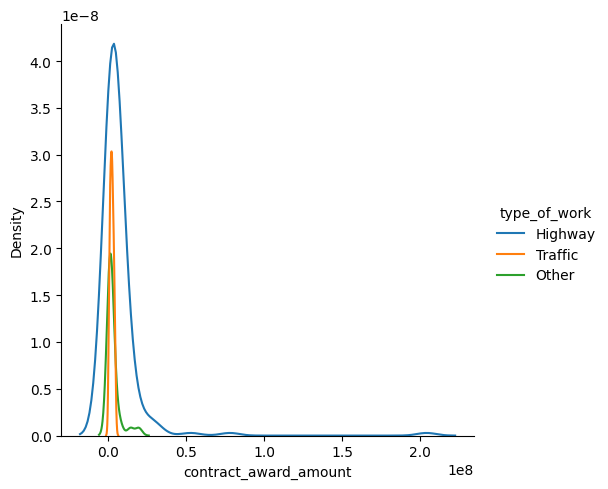

In [30]:
import seaborn as sns
plt.figure(dpi=300)
sns.displot(dropped_contract_numbers, x='contract_award_amount', hue='type_of_work', kind='kde')

In [163]:
cleaned_data = dropped_contract_numbers.drop(columns=['status','contract_award_amount', 'approved_cost_changes','estimated_or_actual_completed_date'])

In [164]:
current_award_amount = location_data.loc[cleaned_data.index, 'current_award_amount']

In [166]:
cleaned_data

,federal_funding,state_funding,local_funding,type_of_work,contract_award_date,latitude,longitude,month,day,year
,,,,,,,,,,
1865,Yes,Yes,No,Highway,2016-04-18,49.870295,19.046648,4,18,2016
1894,No,Yes,No,Highway,2017-05-04,43.001888,-78.785214,5,4,2017
301,No,Yes,No,Traffic,2017-05-15,43.206267,-77.691073,5,15,2017
254,Yes,No,No,Highway,2017-07-20,43.001888,-78.785214,7,20,2017
1289,No,Yes,No,Other,2017-12-12,43.001888,-78.785214,12,12,2017
...,...,...,...,...,...,...,...,...,...,...
1710,Yes,Yes,No,Highway,2021-03-09,43.066991,-76.165387,3,9,2021
884,Yes,Yes,No,Highway,2021-03-12,42.106859,-75.852201,3,12,2021
1344,No,Yes,No,Highway,2021-03-12,40.945188,-72.886521,3,12,2021


<Axes: ylabel='Density'>

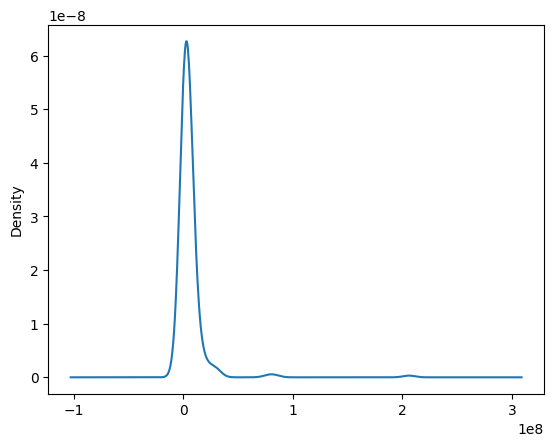

In [167]:
current_award_amount.plot(kind='kde')

In [168]:
z_caa_scores = current_award_amount.apply(lambda x: (x- current_award_amount.mean())/(current_award_amount.std())).copy()

In [169]:
z_caa_scores.drop(index=z_caa_scores[z_caa_scores>3].index, inplace=True)

In [170]:
norm_caa = current_award_amount.apply(lambda x: x/100_000).copy()
norm_caa = norm_caa[z_caa_scores.index]

In [171]:
cleaned_data = cleaned_data.loc[z_caa_scores.index]

In [172]:
norm_caa


1894    223.889015
301       6.578388
254      21.835434
1289     10.675870
42        8.464000
           ...    
1710     39.741378
884      85.360000
1344      2.940645
1294      8.478478
803       5.722370
Name: current_award_amount, Length: 229, dtype: float64

In [180]:
categories = [
	cleaned_data['federal_funding'].unique().tolist(),
	cleaned_data['state_funding'].unique().tolist(),
	cleaned_data['local_funding'].unique().tolist(),
	cleaned_data['type_of_work'].unique().tolist(),
]
ord_columns = [ 'federal_funding', 'state_funding', 'local_funding', 'type_of_work']
ordinal = OrdinalEncoder(categories=categories)
ordinal.fit(cleaned_data[ord_columns])

OrdinalEncoder(categories=[['No', 'Yes'], ['Yes', 'No'], ['No', 'Yes'],
                           ['Highway', 'Traffic', 'Other']])

In [188]:
X_proposed = pd.get_dummies(cleaned_data[ord_columns], dtype='int').join(cleaned_data[['month','day','year','latitude','longitude']], how='left')

In [181]:
from sklearn.preprocessing import KBinsDiscretizer
nun = len(cleaned_data.type_of_work.unique().tolist())
discret = KBinsDiscretizer(n_bins=nun, encode='ordinal', random_state=0)
Y_binned = discret.fit_transform(norm_caa.to_numpy().reshape((-1,1))).ravel()

smote = SMOTENC(categorical_features=[0],random_state=0)
X, Y = smote.fit_resample(np.hstack((ordinal.transform(cleaned_data[ord_columns]),cleaned_data[['month','day','year','latitude','longitude']])), Y_binned)

In [182]:
X

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.01700000e+03,  4.30018880e+01, -7.87852135e+01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.01700000e+03,  4.32062668e+01, -7.76910726e+01],
       [ 1.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         2.01700000e+03,  4.30018880e+01, -7.87852135e+01],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.02100000e+03,  4.05977982e+01, -7.37754897e+01],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.02000000e+03,  4.23324514e+01, -7.67173850e+01],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.01960276e+03,  4.31833909e+01, -7.64631489e+01]])

In [97]:
Y = pd.DataFrame(discret.inverse_transform(Y.reshape((-1,1))),columns=['current_award_amount'])

In [98]:
X = pd.DataFrame(X, columns = ord_columns + ['month','day','year','latitude','longitude'])

In [115]:
# Only for Standardization
# norm_caa = norm_caa.drop(index = norm_caa[norm_caa > 4].index)
# Y.current_award_amount = Y.current_award_amount.apply(lambda x: (x-Y.min())/(Y.max()-Y.min()))

In [99]:
# X.contract_award_amount = X.contract_award_amount.apply(lambda x: x/100_000)

In [100]:
X

,federal_funding,state_funding,local_funding,type_of_work,month,day,year,latitude,longitude
0,0.0,0.0,0.0,0.000000,5.000000,4.000000,2017.000000,43.001888,-78.785214
1,0.0,0.0,0.0,1.000000,5.000000,15.000000,2017.000000,43.206267,-77.691073
2,1.0,1.0,0.0,0.000000,7.000000,20.000000,2017.000000,43.001888,-78.785214
3,0.0,0.0,0.0,2.000000,12.000000,12.000000,2017.000000,43.001888,-78.785214
4,0.0,0.0,0.0,0.000000,1.000000,30.000000,2018.000000,40.883232,-72.857803
...,...,...,...,...,...,...,...,...,...
226,0.0,0.0,0.0,0.000000,3.000000,12.000000,2021.000000,40.945188,-72.886521
227,1.0,0.0,0.0,0.000000,3.000000,15.000000,2021.000000,40.752694,-73.977253
228,0.0,0.0,0.0,0.000000,5.000000,6.000000,2021.000000,40.597798,-73.775490
229,1.0,0.0,0.0,0.000000,2.430379,5.145568,2020.000000,42.332451,-76.717385


In [230]:
# columns_to_transform = ['region', 'federal_funding', 'state_funding', 'local_funding', 'type_of_work']
# transformed_data = pd.DataFrame(np.hstack((ordinal.transform(cleaned_data[columns_to_transform]), cleaned_data[['latitude', 'longitude']].to_numpy())), columns=columns_to_transform + ['latitude', 'longitude'], index=cleaned_data.index)

X_train, X_test, y_train, y_test = train_test_split(X_proposed,norm_caa, test_size=0.4,shuffle=False, random_state=0)

In [231]:
# from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, ExpSineSquared, Exponentiation, RBF, RationalQuadratic
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# kernel = WhiteKernel()

# n_estimators=126, min_samples_split=10, min_samples_leaf=5
# n_estimators=10, min_samples_split=10, min_samples_leaf=6, max_samples=47, 
svr = RandomForestRegressor(random_state=0)
svr.fit(X_train, y_train)

print(f'Training Score: {np.square(y_train.to_numpy().ravel() - svr.predict(X_train)).mean()}')
print(f'Testing Score: {np.square(y_test.to_numpy().ravel() - svr.predict(X_test)).mean()}')   

Training Score: 616.5207689484372
Testing Score: 2020.0734116268052


In [208]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
param_space = dict()
param_space['n_estimators'] = Integer(10,350)
param_space['max_samples'] = Integer(10,100)
param_space['min_samples_split'] = Integer(5,20)
param_space['min_samples_leaf'] = Integer(2,10)
bae = BayesSearchCV(svr, param_space,scoring='neg_mean_squared_error', n_iter=200, n_jobs=16, n_points=4, cv=4, random_state=0)
bae.fit(X_train,y_train)
print(f'Best Params: {bae.best_params_} and Score: {bae.best_score_}')

c:\Users\dwigh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\dwigh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\dwigh\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params: OrderedDict({'max_samples': 99, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 35}) and Score: -3011.759260914523


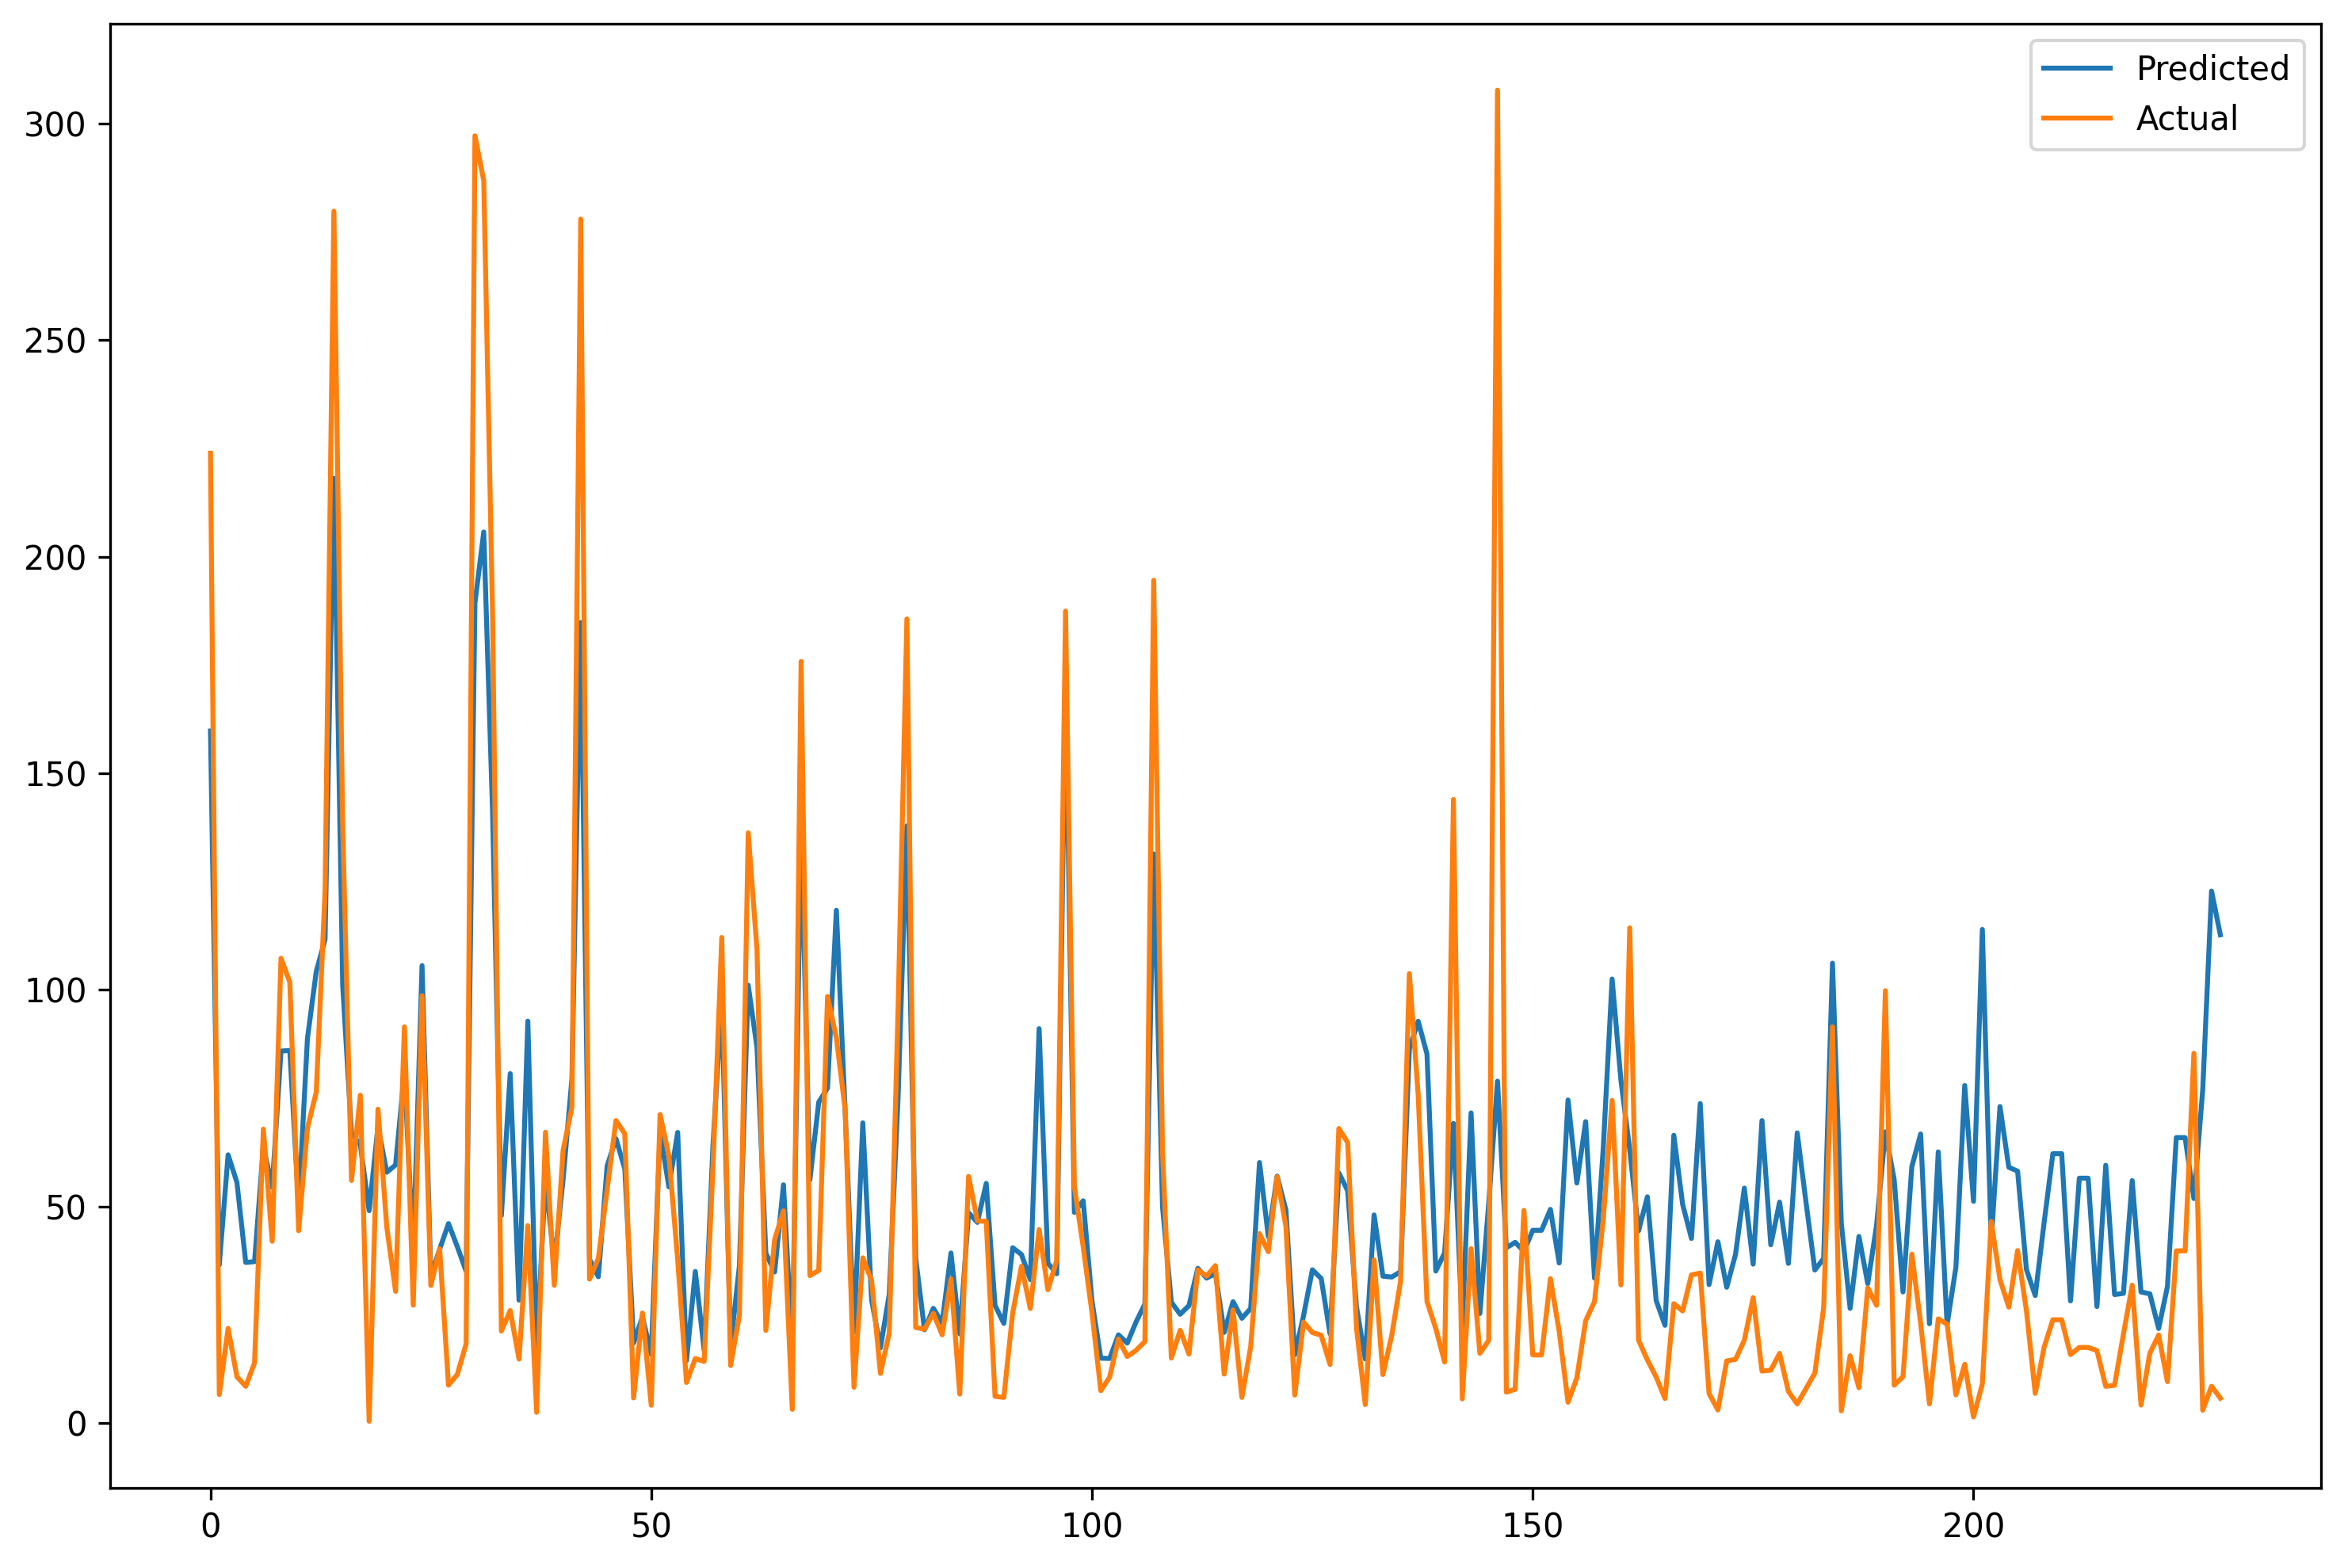

In [232]:
fig, ax = plt.subplots(1,1, figsize=(12,8), dpi=300)
ax.plot(range(X_proposed.shape[0]), svr.predict(X_proposed), label='Predicted')
ax.plot(range(len(norm_caa)),norm_caa, label='Actual')
ax.legend()
plt.show()

In [222]:
rng = np.random.default_rng(seed=0)
def bootstrapp(y_true,y_pred,n_boots):
    rows = len(y_true)
    error = (y_true.to_numpy().ravel() - y_pred)
    S_CI = np.zeros((n_boots,))
    for i in range(n_boots):
        indx = rng.choice(rows, size=rows, replace=True)
        S_CI[i] = np.mean(np.square(error[indx]))
    return S_CI

In [223]:
def pvit(data: pd.DataFrame,y_true: pd.Series, f: callable):
    rows, columns = data.shape
    Vy = np.var(y_true.to_numpy(), axis=0)
    ST = dict()
    CI = dict()
    for col in data.columns:
        d = data.copy()
        perm_feat = np.roll(d[col].to_numpy(),rows//2, axis=0)
        d[col] = perm_feat
        y_pred = f(d)
        ST[col] = np.square(y_true.to_numpy().ravel()-y_pred.ravel()).mean()/(2*Vy)
        S_CI = bootstrapp(y_true, y_pred,1000)/(2*Vy)
        p0,p1 = np.quantile(S_CI, [0.05,1-0.05])
        CI[col] = [p0,p1,p1-p0]
    CI = pd.DataFrame(CI.values(), columns=['5th','95th', 'Quantile Width'], index = CI.keys())
    ST = pd.DataFrame(ST.values(), index=ST.keys(), columns=['ST'])
    print(ST)
    FULL = ST.join(CI)
    return FULL

In [225]:
pvit(X_train, y_train, svr.predict)

                            ST
federal_funding_No    0.098330
federal_funding_Yes   0.099346
state_funding_No      0.087880
state_funding_Yes     0.087081
local_funding_No      0.087148
local_funding_Yes     0.086532
type_of_work_Highway  0.117730
type_of_work_Other    0.091179
type_of_work_Traffic  0.089843
month                 0.147697
day                   0.212800
year                  0.254976
latitude              0.476539
longitude             0.233903


,ST,5th,95th,Quantile Width
federal_funding_No,0.098330,0.066163,0.133299,0.067136
federal_funding_Yes,0.099346,0.070493,0.133699,0.063207
state_funding_No,0.087880,0.062687,0.115553,0.052866
state_funding_Yes,0.087081,0.061014,0.115886,0.054872
local_funding_No,0.087148,0.061967,0.114287,0.052320
local_funding_Yes,0.086532,0.061344,0.116643,0.055299
type_of_work_Highway,0.117730,0.084818,0.152586,0.067767
type_of_work_Other,0.091179,0.063921,0.119313,0.055392
type_of_work_Traffic,0.089843,0.064518,0.118691,0.054172
month,0.147697,0.104197,0.195592,0.091396


In [164]:
pvit(X_train, y_train, RF.predict)

                       ST
federal_funding  0.072495
state_funding    0.072556
local_funding    0.063040
type_of_work     0.211675
month            0.163776
day              0.147903
year             0.184490
latitude         0.216691
longitude        0.274353


,ST,5th,95th,Quantile Width
federal_funding,0.072495,0.061748,0.083938,0.022190
state_funding,0.072556,0.057008,0.089305,0.032297
local_funding,0.063040,0.054447,0.071941,0.017494
type_of_work,0.211675,0.167289,0.258051,0.090762
month,0.163776,0.138574,0.188030,0.049455
day,0.147903,0.123540,0.174228,0.050688
year,0.184490,0.146064,0.222625,0.076561
latitude,0.216691,0.183160,0.252752,0.069591
longitude,0.274353,0.232364,0.317739,0.085374


In [162]:
def pvi(data: pd.DataFrame,y_true: pd.Series, f: callable):
    rows, columns = data.shape
    Vy = np.var(y_true, axis=0)
    SI = dict()
    rolled_data = pd.DataFrame(np.roll(data.to_numpy(),1, axis=0), columns=data.columns)
    for col in data.columns:
        r = rolled_data.copy()
        r[col] = data[col]
        y_pred = f(r)
        SI[col] = 1 - np.square(y_true.to_numpy() - y_pred).mean()/(2*Vy)
    return SI

In [163]:
pvi(X_train, y_train, RF.predict)

{'federal_funding': current_award_amount    0.244906
 dtype: float64,
 'state_funding': current_award_amount    0.233753
 dtype: float64,
 'local_funding': current_award_amount    0.234692
 dtype: float64,
 'type_of_work': current_award_amount    0.264812
 dtype: float64,
 'month': current_award_amount    0.237618
 dtype: float64,
 'day': current_award_amount    0.268029
 dtype: float64,
 'year': current_award_amount    0.233176
 dtype: float64,
 'latitude': current_award_amount    0.318998
 dtype: float64,
 'longitude': current_award_amount    0.328236
 dtype: float64}

In [160]:
def pvi2(data: pd.DataFrame,y_true: pd.Series, f: callable, SI: dict):
    rows, columns = data.shape
    Vy = np.var(y_true)
    SIK = dict()
    rolled_data = pd.DataFrame(np.roll(data.to_numpy(),1, axis=0), columns=data.columns)
    for col1, col2 in it.combinations(data.columns,r=2):
        r = rolled_data.copy()
        r[[col1, col2]] = data[[col1, col2]]
        y_pred = f(r)
        SIK[(col1,col2)] = 1 - np.square(y_true.to_numpy() - y_pred).mean()/(2*Vy) - SI[col1] - SI[col2]
    return SIK

In [33]:
def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

In [34]:
pd.set_option('display.max_rows', 300)
loc_data = time_features(location_data)
design_of_expmt = loc_data.groupby(by=['region']).agg({'contract_award_amount':['mean','std'],'current_award_amount':[percentile(0.75), 'max']})

In [35]:
design_of_expmt

contract_award_amount                \
                                                   mean           std   
region                                                                  
01 CAPITAL DISTRICT                        6.456343e+06  6.434021e+06   
02 MOHAWK VALLEY                           3.508626e+06  3.257692e+06   
03 CENTRAL NEW YORK                        4.871855e+06  5.579256e+06   
04 GENESEE VALLEY                          2.999064e+06  2.645262e+06   
05 WESTERN NEW YORK                        2.357014e+06  1.906999e+06   
06 SOUTHERN TIER/CENTRAL NEW YORK          2.106953e+06  1.656043e+06   
07 NORTH COUNTRY                           1.216049e+06  5.783098e+05   
08 HUDSON VALLEY                           3.059596e+06  2.769427e+06   
09 SOUTHERN TIER                           2.773528e+06  2.449280e+06   
10 LONG ISLAND                             7.993993e+06  6.344034e+06   
11 NEW YORK CITY                           2.894821e+07  4.806008e+07   

                                  current_award_amount                
                                         percentile_75           max  
region                                                                
01 CAPITAL DISTRICT                       7.507609e+06  2.971630e+07  
02 MOHAWK VALLEY                          4.109431e+06  1.868201e+07  
03 CENTRAL NEW YORK                       5.891915e+06  1.945590e+07  
04 GENESEE VALLEY                         3.625838e+06  1.072882e+07  
05 WESTERN NEW YORK                       2.993791e+06  8.536000e+06  
06 SOUTHERN TIER/CENTRAL NEW YORK         2.679564e+06  6.167580e+06  
07 NORTH COUNTRY                          1.405395e+06  2.136505e+06  
08 HUDSON VALLEY                          3.959390e+06  1.376475e+07  
09 SOUTHERN TIER                          2.991240e+06  1.091397e+07  
10 LONG ISLAND                            8.768973e+06  2.867904e+07  
11 NEW YORK CITY                          2.793070e+07  2.059000e+08

In [36]:
design_of_expmt = pd.DataFrame(design_of_expmt.to_numpy(), index=design_of_expmt.index, columns=['mean','std','75th Percentile','Max'])

In [37]:
design_of_expmt

,mean,std,75th Percentile,Max
region,,,,
01 CAPITAL DISTRICT,6.456343e+06,6.434021e+06,7.507609e+06,2.971630e+07
02 MOHAWK VALLEY,3.508626e+06,3.257692e+06,4.109431e+06,1.868201e+07
03 CENTRAL NEW YORK,4.871855e+06,5.579256e+06,5.891915e+06,1.945590e+07
04 GENESEE VALLEY,2.999064e+06,2.645262e+06,3.625838e+06,1.072882e+07
05 WESTERN NEW YORK,2.357014e+06,1.906999e+06,2.993791e+06,8.536000e+06
06 SOUTHERN TIER/CENTRAL NEW YORK,2.106953e+06,1.656043e+06,2.679564e+06,6.167580e+06
07 NORTH COUNTRY,1.216049e+06,5.783098e+05,1.405395e+06,2.136505e+06
08 HUDSON VALLEY,3.059596e+06,2.769427e+06,3.959390e+06,1.376475e+07
09 SOUTHERN TIER,2.773528e+06,2.449280e+06,2.991240e+06,1.091397e+07


In [38]:
import scipy.stats as ss 
def MC(data: pd.DataFrame):
    index = data.index
    rang_feat = {col: data.loc[col, ['mean','std', 'Max']] for col in index}
    sommand = 0
    for indx in index:
        mini,std, maxi  = rang_feat[indx]
        probs = np.random.normal(loc=mini, scale=np.abs(maxi-mini), size=1_000_000)
        sommand += probs
    return sommand
total_cost = MC(design_of_expmt)

The 95% CDF value for a normal distribution with mean=66,199,093.750737704 and std_dev=181,737,207.64116788 is: 365,130,198.8913455


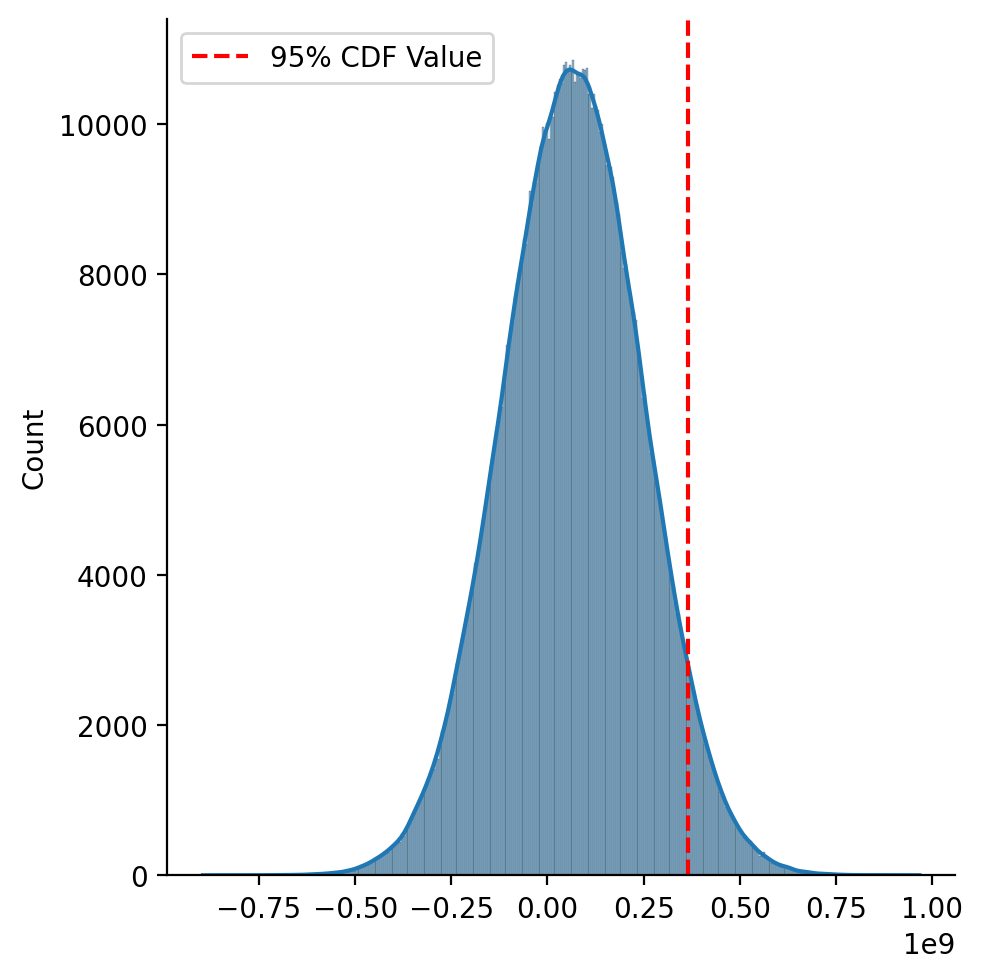

In [40]:
# plt.figure(figsize=(8,12),dpi=500)
sns.displot(total_cost.flatten(), kde=True).fig.set_dpi(200)
cdf_values = ss.norm.ppf(loc = total_cost.mean(), scale=total_cost.std(), q=0.95)
print(f"The 95% CDF value for a normal distribution with mean={total_cost.mean():,} and std_dev={total_cost.std():,} is: {cdf_values:,}")
plt.axvline(x=cdf_values, color='red', linestyle='--', label='95% CDF Value')
plt.legend()
plt.show()

In [42]:
cdf_values = ss.norm.ppf(loc = total_cost.mean(), scale=total_cost.std(), q=0.95)
print(f"The 95% CDF value for a normal distribution with mean={total_cost.mean():,} and std_dev={total_cost.std():,} is: {cdf_values:,}")

The 95% CDF value for a normal distribution with mean=66,199,093.750737704 and std_dev=181,737,207.64116788 is: 365,130,198.8913455


In [232]:
design_of_expmt[['mean','Max']].to_numpy().sum(axis=0)

array([6.62912306e+07, 3.54680879e+08])

In [ ]:
class Probabilistic_Imputation:
    def __init__(self):
        self.likelihoods = dict()

    def fit(self, data: np.ndarray):
        self.y_priors = self.gaussian(data)
        hist, bins = np.histogram(data[:,-1], bins=data.shape[0]/2)
        for el in data[:,-1]:
            
    @staticmethod
    def gaussian(self, data: np.ndarray):
        return np.exp(-np.square((data[:,-1] - data[:,-1].mean())/data[:,-1].std()))/(np.sqrt(2*np.pi)*data[:,-1].std())

In [170]:
# from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
# X_DCN = dropped_contract_numbers.loc[:,new_x_columns]
# Y = dropped_contract_numbers.loc[:,y_column]
# nun = len(X_DCN.type_of_work.unique())
# discret = KBinsDiscretizer(n_bins=nun, encode='ordinal', random_state=0)
# Y_binned = discret.fit_transform(Y.to_numpy().reshape((-1,1))).ravel()

# smote = SMOTEN(sampling_strategy='minority',random_state=0)
# X, Y = smote.fit_resample(X_DCN, Y_binned)